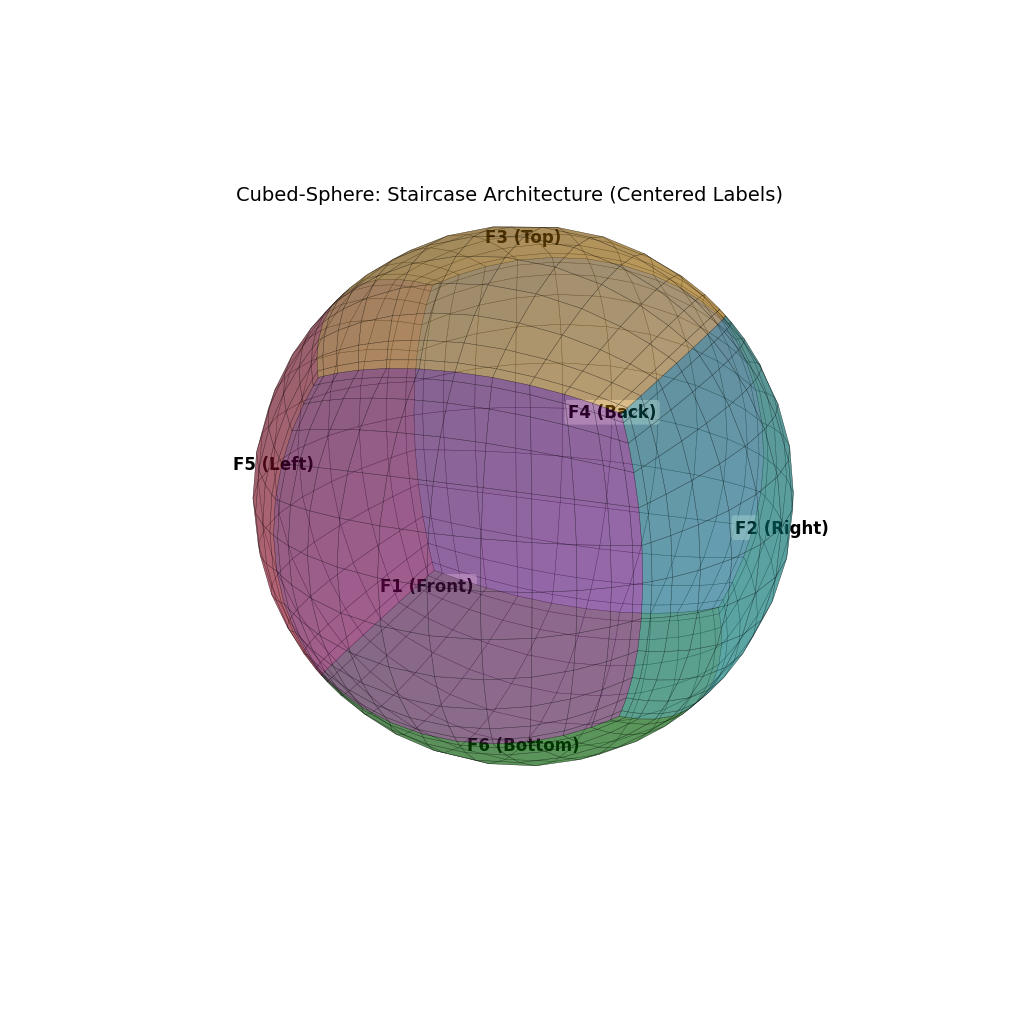

In [92]:
# %%
import numpy as np
from numpy.polynomial import legendre as LG
import matplotlib.pyplot as plt
import math
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

# %%
N = 12  # 網格解析度
a = 1.0
R = np.sqrt(3.0) * a

# %%
def legendre_gll_nodes(N):
    """Return the N+1 Legendre–Gauss–Lobatto nodes in [-1,1]."""
    if N == 1:
        return np.array([-1.0, 1.0])
    Pn = LG.Legendre.basis(N)
    dPn = Pn.deriv()
    interior = dPn.roots()
    nodes = np.concatenate(([-1.0], interior, [1.0]))
    return np.sort(nodes)

# %%
def P1(N):
    xi = legendre_gll_nodes(N)
    eta = legendre_gll_nodes(N)
    xi, eta = np.meshgrid(xi, eta, indexing='ij') # Ensure consistency
    alpha = xi * np.pi * (1/4)
    beta = eta * np.pi * (1/4)
    return alpha, beta

# %% [markdown]
# ### Staircase (Ladder) Architecture Mapping
# Based on app1 (1).pdf definitions
# F1: (a, x, y)
# F2: (-x, a, y)
# F3: (-x, -y, a)
# F4: (-a, -y, -x)
# F5: (y, -a, -x)
# F6: (y, x, -a)

# %%
def sphere_C1(N, a, R):
    # F1 (Front): (a, x, y)
    alpha, beta = P1(N)
    x = a * np.tan(alpha)
    y = a * np.tan(beta)
    r = np.sqrt(a**2 + x**2 + y**2)
    c = R / r
    X = c * a
    Y = c * x
    Z = c * y
    return X, Y, Z

def sphere_C2(N, a, R):
    # F2 (Right): (-x, a, y)
    alpha, beta = P1(N)
    x = a * np.tan(alpha)
    y = a * np.tan(beta)
    r = np.sqrt(a**2 + x**2 + y**2)
    c = R / r
    X = c * (-x)
    Y = c * a
    Z = c * y
    return X, Y, Z

def sphere_C3(N, a, R):
    # F3 (Top/North): (-x, -y, a)  <-- Modified for Staircase
    alpha, beta = P1(N)
    x = a * np.tan(alpha)
    y = a * np.tan(beta)
    r = np.sqrt(a**2 + x**2 + y**2)
    c = R / r
    X = c * (-x)
    Y = c * (-y)
    Z = c * a
    return X, Y, Z

def sphere_C4(N, a, R):
    # F4 (Back): (-a, -y, -x)      <-- Modified for Staircase
    alpha, beta = P1(N)
    x = a * np.tan(alpha)
    y = a * np.tan(beta)
    r = np.sqrt(a**2 + x**2 + y**2)
    c = R / r
    X = c * (-a)
    Y = c * (-y)
    Z = c * (-x)
    return X, Y, Z

def sphere_C5(N, a, R):
    # F5 (Left): (y, -a, x)        <-- Modified for Staircase
    # Note: Corrected vector based on derivation: x corresponds to Z, y corresponds to X
    alpha, beta = P1(N)
    x = a * np.tan(alpha)
    y = a * np.tan(beta)
    r = np.sqrt(a**2 + x**2 + y**2)
    c = R / r
    X = c * y
    Y = c * (-a)
    Z = c * -x
    return X, Y, Z

def sphere_C6(N, a, R):
    # F6 (Bottom/South): (y, x, -a) <-- Modified for Staircase
    alpha, beta = P1(N)
    x = a * np.tan(alpha)
    y = a * np.tan(beta)
    r = np.sqrt(a**2 + x**2 + y**2)
    c = R / r
    X = c * y
    Y = c * x
    Z = c * (-a)
    return X, Y, Z



# %%
def lonlat_from_xyz(X, Y, Z, R):
    lam = np.arctan2(Y, X)         # (-pi, pi]
    the = np.arcsin(np.clip(Z/R, -1.0, 1.0))
    return lam, the

def cosine_bell_on_xyz(X, Y, Z, R, h0=1000.0):
    lam, the = lonlat_from_xyz(X, Y, Z, R)
    lam_c, the_c = (3/2)*np.pi, 0.0 # Center at 270 deg (Face 4 center approx)

    # great-circle distance
    cos_gamma = np.sin(the)*np.sin(the_c) + np.cos(the)*np.cos(the_c)*np.cos(lam - lam_c)
    cos_gamma = np.clip(cos_gamma, -1.0, 1.0)
    gamma = np.arccos(cos_gamma)
    rd = R * gamma

    r0 = R/3.0
    phi = np.zeros_like(rd)
    mask = (rd < r0)
    phi[mask] = 0.5*h0*(1.0 + np.cos(np.pi*rd[mask]/r0))
    return phi

# # %%
# # 繪製 Cosine Bell 初始場 (驗證幾何連通性)
# fig = plt.figure(figsize=(8,6))
# ax = fig.add_subplot(111, projection='3d')

# # Global normalization for colorbar
# phis = []
# xyzs = []
# for f in faces:
#     X, Y, Z = f(N, a, R)
#     xyzs.append((X, Y, Z))
#     phis.append(cosine_bell_on_xyz(X, Y, Z, R))
# phi_all = np.concatenate([p.ravel() for p in phis])
# pmin, pmax = phi_all.min(), phi_all.max()

# for (X, Y, Z), p in zip(xyzs, phis):
#     fc = plt.cm.viridis((p - pmin) / (pmax - pmin + 1e-12))
#     ax.plot_surface(X, Y, Z, facecolors=fc, rstride=1, cstride=1, linewidth=0, antialiased=False, shade=False)

# ax.set_title('Cosine-bell on Staircase Architecture')
# ax.set_box_aspect([1,1,1])
# plt.show()

# %%
# Visual Check for Staircase Architecture
# (假設 N, a, R 以及 sphere_C1~C6 函數已經在前面的 cell 定義過了)
# %%
# Visual Check for Staircase Architecture
# (假設 N, a, R 以及 sphere_C1~C6 函數已經在前面的 cell 定義過了)
# %%
# Visual Check for Staircase Architecture
# (假設 N, a, R 以及 sphere_C1~C6 函數已經在前面的 cell 定義過了)

faces = [sphere_C1, sphere_C2, sphere_C3, sphere_C4, sphere_C5, sphere_C6]
colors = ['purple','teal','orange','royalblue','crimson','darkgreen']
face_names = ['F1 (Front)', 'F2 (Right)', 'F3 (Top)', 'F4 (Back)', 'F5 (Left)', 'F6 (Bottom)']

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

for f, c, name in zip(faces, colors, face_names):
    X, Y, Z = f(N, a, R)
    
    # 1. 繪製表面
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.4, color=c, edgecolor='k', linewidth=0.3, antialiased=True)
    
    # 2. 標註文字
    mid = X.shape[0] // 2 
    cx, cy, cz = X[mid, mid], Y[mid, mid], Z[mid, mid]
    
    push_factor = 1.0 
    
    ax.text(cx * push_factor, cy * push_factor, cz * push_factor, 
            name, 
            fontsize=12,        
            fontweight='bold',  
            color='black',      
            horizontalalignment='center',
            verticalalignment='center',
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.2')
            )

# --- 設定視角與外觀 ---

# 標題位置 (因為球體變大了，標題稍微再往上一點點以免重疊，設 0.9 左右)
ax.set_title('Cubed-Sphere: Staircase Architecture (Centered Labels)', fontsize=14, y=0.87)

ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
lim = R * 1.1 
ax.set_xlim([-lim, lim]); ax.set_ylim([-lim, lim]); ax.set_zlim([-lim, lim])
ax.set_box_aspect([1,1,1])

# 設定視角
ax.view_init(elev=20, azim=20) 

# 【關鍵修改 1】拉近鏡頭 (Zoom In)
# 預設值約為 10，數值越小代表相機離物體越近，球體就會看起來越大
ax.dist = 7.5  

# 移除背景與座標軸
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.axis('off')

# 【關鍵修改 2】移除畫布邊緣的留白
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)

# 【關鍵修改 3】存檔時 pad_inches=0 代表完全不留白邊
plt.savefig('cubed_sphere_tight.png', dpi=300, bbox_inches='tight', pad_inches=0, transparent=True)
plt.show()

In [93]:
def get_alpha_beta(N):
    xi = legendre_gll_nodes(N)
    eta = legendre_gll_nodes(N)
    xi_mesh, eta_mesh = np.meshgrid(xi, eta, indexing='ij') 
    alpha = xi_mesh * (np.pi / 4.0)
    beta = eta_mesh * (np.pi / 4.0)
    return alpha, beta

def get_global_coords(face_id, N, a, R):
    face_map = {1: sphere_C1, 2: sphere_C2, 3: sphere_C3, 4: sphere_C4, 5: sphere_C5, 6: sphere_C6}
    return face_map[face_id](N, a, R)



import numpy as np

def get_metrics(N, a, R, face_id):
    """
    Calculate metric terms for Cubed-Sphere Staircase architecture using specific
    Matrix A and Jacobian J formulas provided by the user.
    """
    # 1. Get alpha, beta from grid
    alpha, beta = get_alpha_beta(N)
    
    # 2. Get Global Coordinates and Longitude/Latitude
    X, Y, Z = get_global_coords(face_id, N, a, R)
    # plt.plot(X, Y)
    lam, the = lonlat_from_xyz(X, Y, Z, R)
    # plt.plot(lam, the)
    
    
    # 3. Pre-compute Trigonometric functions
    # Lambda, Theta
    sin_lam = np.sin(lam)
    cos_lam = np.cos(lam)
    # tan_lam = np.tan(lam) # Not strictly needed if using sin/cos formulas
    
    sin_the = np.sin(the)
    cos_the = np.cos(the)
    
    # Alpha, Beta (for sec terms)
    sec_alpha = 1.0 / np.cos(alpha)
    sec_beta  = 1.0 / np.cos(beta)
    
    # Squared terms for efficiency
    cos2_lam = cos_lam**2
    sin2_lam = sin_lam**2
    cos2_the = cos_the**2
    sin2_the = sin_the**2
    
    sec2_alpha = sec_alpha**2
    sec2_beta  = sec_beta**2
    
    # Initialize Matrix A and sqrt_g
    A = np.zeros((2, 2, N+1, N+1))
    sqrt_g = np.zeros((N+1, N+1))
    
    # Helper term for A21/A22 in F1, F2, F4, F5 involving cos(2(lam +/- theta))
    # cos(2(a-b)) = cos(2a - 2b)
    # cos(2(a+b)) = cos(2a + 2b)
    
    term_diff = np.cos(2 * (lam - the))
    term_sum  = np.cos(2 * (lam + the))
    
    # 4. Compute A components and Jacobian based on Face ID
    if face_id == 1:
        # F1
        # A11 = R * cos^2(lam) * cos(the) * sec^2(alpha)
        A[0, 0] = R * cos2_lam * cos_the * sec2_alpha
        # A12 = 0
        A[0, 1] = 0.0
        # A21 = (R/8) * (-cos(2(l-t)) + cos(2(l+t))) * sec^2(alpha)
        A[1, 0] = (R / 8.0) * (-term_diff + term_sum) * sec2_alpha
        # A22 = R * cos(lam) * cos^2(the) * sec^2(beta)
        A[1, 1] = R * cos_lam * cos2_the * sec2_beta
        
        # J = [R^2 * cos^2(lam) * cos^2(the) * |cos(lam)cos(the)|] / [cos^2(alpha) * cos^2(beta)]
        numerator = (R**2) * cos2_lam * cos2_the * np.abs(cos_lam * cos_the)
        sqrt_g = numerator * sec2_alpha * sec2_beta

    elif face_id == 2:
        # F2
        # A11 = R * sin^2(lam) * cos(the) * sec^2(alpha)
        A[0, 0] = R * sin2_lam * cos_the * sec2_alpha
        # A12 = 0
        A[0, 1] = 0.0
        # A21 = (R/8) * (cos(2(l-t)) - cos(2(l+t))) * sec^2(alpha)
        A[1, 0] = (R / 8.0) * (term_diff - term_sum) * sec2_alpha
        # A22 = R * sin(lam) * cos^2(the) * sec^2(beta)
        A[1, 1] = R * sin_lam * cos2_the * sec2_beta
        
        # J = [R^2 * sin^2(lam) * cos^2(the) * |sin(lam)cos(the)|] / [cos^2(alpha) * cos^2(beta)]
        numerator = (R**2) * sin2_lam * cos2_the * np.abs(sin_lam * cos_the)
        sqrt_g = numerator * sec2_alpha * sec2_beta

    elif face_id == 3:
        # F3
        # A11 = R * sin(lam) * sin(the) * sec^2(alpha)
        A[0, 0] = R * sin_lam * sin_the * sec2_alpha
        # A12 = -R * sin(the) * cos(lam) * sec^2(beta)
        A[0, 1] = -R * sin_the * cos_lam * sec2_beta
        # A21 = R * sin^2(the) * cos(lam) * sec^2(alpha)
        A[1, 0] = R * sin2_the * cos_lam * sec2_alpha
        # A22 = R * sin(lam) * sin^2(the) * sec^2(beta)
        A[1, 1] = R * sin_lam * sin2_the * sec2_beta
        
        # J = [R^2 * sin^2(the) * |sin(the)|] / [cos^2(alpha) * cos^2(beta)]
        numerator = (R**2) * sin2_the * np.abs(sin_the)
        sqrt_g = numerator * sec2_alpha * sec2_beta

    elif face_id == 4:
        # F4
        # A11 = 0
        A[0, 0] = 0.0
        # A12 = R * cos^2(lam) * cos(the) * sec^2(beta)
        A[0, 1] = R * cos2_lam * cos_the * sec2_beta
        # A21 = R * cos(lam) * cos^2(the) * sec^2(alpha)
        A[1, 0] = R * cos_lam * cos2_the * sec2_alpha
        # A22 = (R/8) * (-cos(2(l-t)) + cos(2(l+t))) * sec^2(beta)
        A[1, 1] = (R / 8.0) * (-term_diff + term_sum) * sec2_beta
        
        # J = [R^2 * cos^2(lam) * cos^2(the) * |cos(lam)cos(the)|] / [cos^2(alpha) * cos^2(beta)]
        numerator = (R**2) * cos2_lam * cos2_the * np.abs(cos_lam * cos_the)
        sqrt_g = numerator * sec2_alpha * sec2_beta

    elif face_id == 5:
        # F5
        # A11 = 0
        A[0, 0] = 0.0
        # A12 = R * sin^2(lam) * cos(the) * sec^2(beta)
        A[0, 1] = R * sin2_lam * cos_the * sec2_beta
        # A21 = R * sin(lam) * cos^2(the) * sec^2(alpha)
        A[1, 0] = R * sin_lam * cos2_the * sec2_alpha
        # A22 = (R/8) * (cos(2(l-t)) - cos(2(l+t))) * sec^2(beta)
        A[1, 1] = (R / 8.0) * (term_diff - term_sum) * sec2_beta
        
        # J = [R^2 * sin^2(lam) * cos^2(the) * |sin(lam)cos(the)|] / [cos^2(alpha) * cos^2(beta)]
        numerator = (R**2) * sin2_lam * cos2_the * np.abs(sin_lam * cos_the)
        sqrt_g = numerator * sec2_alpha * sec2_beta

    elif face_id == 6:
        # F6
        # A11 = -R * sin(the) * cos(lam) * sec^2(alpha)
        A[0, 0] = -R * sin_the * cos_lam * sec2_alpha
        # A12 = R * sin(lam) * sin(the) * sec^2(beta)
        A[0, 1] = R * sin_lam * sin_the * sec2_beta
        # A21 = R * sin(lam) * sin^2(the) * sec^2(alpha)
        A[1, 0] = R * sin_lam * sin2_the * sec2_alpha
        # A22 = R * sin^2(the) * cos(lam) * sec^2(beta)
        A[1, 1] = R * sin2_the * cos_lam * sec2_beta
        
        # J = [R^2 * sin^2(the) * |sin(the)|] / [cos^2(alpha) * cos^2(beta)]
        numerator = (R**2) * sin2_the * np.abs(sin_the)
        sqrt_g = numerator * sec2_alpha * sec2_beta

    # 5. Compute Inverse Matrix A_inv
    # det(A) = A00*A11 - A01*A10
    det_A = A[0, 0] * A[1, 1] - A[0, 1] * A[1, 0]
    
    # Avoid division by zero
    inv_det = 1.0 / (det_A + 1e-20)
    
    A_inv = np.zeros_like(A)
    A_inv[0, 0] =  A[1, 1] * inv_det
    A_inv[0, 1] = -A[0, 1] * inv_det
    A_inv[1, 0] = -A[1, 0] * inv_det
    A_inv[1, 1] =  A[0, 0] * inv_det
    
    return sqrt_g, A_inv

In [94]:
# %%
# Test Block: Check F1 Center values
sqrt_g_test, A_inv_test = get_metrics(N, a, R, 1)
center = N // 2
print(f"Face 1 Center Sqrt(g): {sqrt_g_test[center, center]:.4f} (Expected: {R**2:.4f})")
print(f"Face 1 Center A_inv:\n{A_inv_test[:,:,center,center]}")

# %% [Flux Module remains standard]
def get_global_wind_solid_body(lam, the, R, u0,alpha0=0):
    u_global = u0 * (np.cos(alpha0) * np.cos(the) + np.sin(alpha0) * np.cos(lam) * np.sin(the))
    v_global = -u0 * (np.sin(alpha0) * np.sin(lam))
    return u_global, v_global

def compute_fluxes(U_conserved, u_global, v_global, A_inv):
    """
    計算 DG 通量 F(U) 和 G(U) 以及逆變風速
    
    Args:
        U_conserved: 守恆變數 U = sqrt(g) * phi, shape (N+1, N+1)
        u_global: 球面東西向物理風速 u (m/s)
        v_global: 球面南北向物理風速 v (m/s)
        A_inv: 逆變換矩陣, shape (2, 2, N+1, N+1)
        
    Returns:
        F: alpha 方向通量 (u^1 * U)
        G: beta  方向通量 (u^2 * U)
        u_contra: 逆變風速 alpha_dot (u^1)
        v_contra: 逆變風速 beta_dot  (u^2)
    """
    # 1. 計算逆變風速 (Contravariant Velocity)
    # [u^1]   [A_inv_00  A_inv_01] [u]
    # [u^2] = [A_inv_10  A_inv_11] [v]
    
    u_contra = A_inv[0, 0] * u_global + A_inv[0, 1] * v_global
    v_contra = A_inv[1, 0] * u_global + A_inv[1, 1] * v_global
    
    # 2. 計算通量 F = u^1 * U, G = u^2 * U
    F = u_contra * U_conserved
    G = v_contra * U_conserved
    
    return F, G, u_contra, v_contra

Face 1 Center Sqrt(g): 3.0000 (Expected: 3.0000)
Face 1 Center A_inv:
[[ 0.57735027 -0.        ]
 [-0.          0.57735027]]


In [95]:
def get_derivative_matrix(N):
    """
    計算 Legendre-Gauss-Lobatto (LGL) 節點的微分矩陣 D_ij
    D_ij = dL_j(xi_i) / dxi
    
    這是 Spectral Element Method 的核心，用於精確微分。
    """
    # 1. 取得 LGL 節點
    xi = legendre_gll_nodes(N)
    
    # 2. 計算 Legendre 多項式在節點上的值 L_N(xi)
    # P_N(xi) 在 LGL 節點上只會是 1 或 -1 (端點) 或其他值
    # 這裡直接利用 scipy/numpy 的 polynomial 模組計算
    Pn = LG.Legendre.basis(N)
    Ln_xi = Pn(xi)
    
    D = np.zeros((N+1, N+1))
    
    for i in range(N+1):
        for j in range(N+1):
            if i != j:
                D[i, j] = Ln_xi[i] / (Ln_xi[j] * (xi[i] - xi[j]))
            elif i == j and i == 0:
                D[i, j] = -N * (N + 1) / 4.0
            elif i == j and i == N:
                D[i, j] = N * (N + 1) / 4.0
            else:
                D[i, j] = 0.0
                
    return D

In [96]:
import numpy as np
from numpy.polynomial import legendre as LG
import matplotlib.pyplot as plt

# ... (保留原本的基礎函數 get_metrics, get_derivative_matrix, compute_fluxes 等，此處省略以節省篇幅，直接使用您環境中已定義的函數) ...

def compute_split_divergence_terms(phi, u_contra, v_contra, sqrt_g, D):
    """
    計算 Skew-Symmetric (Split) Form 的各個分項數值。
    
    公式: R = 0.5 * Term1 + 0.5 * Term2 + 0.5 * Term3
    Term 1 (Flux):       div(phi * u)
    Term 2 (Advective):  u . grad(phi)
    Term 3 (Correction): phi * div(u)
    """
    # 1. Mapping Factor
    map_factor = 4.0 / np.pi
    
    # -------------------------------------------------------
    # Term 1: Flux Term (Conservative Form) -> div(phi * u)
    # -------------------------------------------------------
    flux_alpha = sqrt_g * u_contra * phi
    flux_beta  = sqrt_g * v_contra * phi
    
    dF_da = (D @ flux_alpha) * map_factor
    dF_db = (flux_beta @ D.T) * map_factor
    
    # 原始 Flux Term 值
    term1_raw = (dF_da + dF_db) / (sqrt_g)

    # -------------------------------------------------------
    # Term 2: Advective Term -> u . grad(phi)
    # -------------------------------------------------------
    dphi_da = (D @ phi) * map_factor
    dphi_db = (phi @ D.T) * map_factor
    
    # 原始 Advective Term 值
    term2_raw = u_contra * dphi_da + v_contra * dphi_db

    # -------------------------------------------------------
    # Term 3: Correction/Divergence Term -> phi * div(u)
    # -------------------------------------------------------
    G_u = sqrt_g * u_contra
    G_v = sqrt_g * v_contra
    
    dGu_da = (D @ G_u) * map_factor
    dGv_db = (G_v @ D.T) * map_factor
    
    div_v = (1/sqrt_g) * (dGu_da + dGv_db)
    
    # 原始 Correction Term 值
    term3_raw = phi * div_v
    
    # -------------------------------------------------------
    # Final Combination (Weighted)
    # -------------------------------------------------------
    # 根據公式：1/2 * Flux + 1/2 * Adv + 1/2 * Corr
    term1_weighted = 0.5 * term1_raw
    term2_weighted = 0.5 * term2_raw
    term3_weighted = 0.5 * term3_raw
    
    div_total = term1_weighted + term2_weighted + term3_weighted
    
    return div_total, term1_weighted, term2_weighted, term3_weighted

def verify_split_form_terms_constant(N, a, R, u0,alpha0=np.pi/4):
    print(f"=== Split Form Terms Analysis (Constant Field phi=1.0) ===")
    
    D = get_derivative_matrix(N)
    
    # 儲存每個面的統計數據
    faces_stats = []

    for face_id in range(1, 7):
        # 1. 幾何與風場
        sqrt_g, A_inv = get_metrics(N, a, R, face_id)
        X, Y, Z = get_global_coords(face_id, N, a, R)
        lam, the = lonlat_from_xyz(X, Y, Z, R)
        
        # 2. Constant Field
        phi_init = np.ones_like(sqrt_g)
        
        u_phys, v_phys = get_global_wind_solid_body(lam, the, R, u0,alpha0)
        
        # 3. 逆變風速
        _, _, u_contra, v_contra = compute_fluxes(np.ones_like(sqrt_g), u_phys, v_phys, A_inv)
        
        # 4. 計算各項 (包含加權後的結果)
        div_total, t1, t2, t3 = compute_split_divergence_terms(phi_init, u_contra, v_contra, sqrt_g, D)
        
        stats = {
            "id": face_id,
            "t1_max": np.max(np.abs(t1)), # 0.5 * div(phi*u)
            "t2_max": np.max(np.abs(t2)), # 0.5 * u.grad(phi)
            "t3_max": np.max(np.abs(t3)), # 0.5 * phi*div(u)
            "total_max": np.max(np.abs(div_total))
        }
        faces_stats.append(stats)

        # Print detailed output for this face
        print(f"Face {face_id}:")
        print(f"  1. Flux Term (0.5*div(phi*u)): {stats['t1_max']:.4e}")
        print(f"  2. Adv  Term (0.5*u.grad):     {stats['t2_max']:.4e}")
        print(f"  3. Corr Term (0.5*phi*div(u)): {stats['t3_max']:.4e}")
        print(f"  => Total Divergence:           {stats['total_max']:.4e}")
        print("-" * 40)

# 執行分析
u0 = (2.0 * np.pi * R) / (12.0 * 24.0 * 3600.0)
N = 500
a = 1.0
R = np.sqrt(3.0) * a
verify_split_form_terms_constant(N, a, R, u0,alpha0=np.pi/4)

=== Split Form Terms Analysis (Constant Field phi=1.0) ===
Face 1:
  1. Flux Term (0.5*div(phi*u)): 5.1467e-11
  2. Adv  Term (0.5*u.grad):     5.1467e-11
  3. Corr Term (0.5*phi*div(u)): 5.1467e-11
  => Total Divergence:           1.5440e-10
----------------------------------------
Face 2:
  1. Flux Term (0.5*div(phi*u)): 5.1922e-11
  2. Adv  Term (0.5*u.grad):     5.1922e-11
  3. Corr Term (0.5*phi*div(u)): 5.1922e-11
  => Total Divergence:           1.5577e-10
----------------------------------------
Face 3:
  1. Flux Term (0.5*div(phi*u)): 5.1467e-11
  2. Adv  Term (0.5*u.grad):     5.1467e-11
  3. Corr Term (0.5*phi*div(u)): 5.1467e-11
  => Total Divergence:           1.5440e-10
----------------------------------------
Face 4:
  1. Flux Term (0.5*div(phi*u)): 5.1467e-11
  2. Adv  Term (0.5*u.grad):     5.1467e-11
  3. Corr Term (0.5*phi*div(u)): 5.1467e-11
  => Total Divergence:           1.5440e-10
----------------------------------------
Face 5:
  1. Flux Term (0.5*div(phi*u)): 

In [97]:
import numpy as np
import matplotlib.pyplot as plt

# 假設 compute_split_divergence_terms 與其他基礎函數已經定義在您的環境中
# 此處直接使用您提供的 compute_split_divergence_terms

def get_cosine_bell_field(lam, the, R,h0):
    """
    產生標準 Cosine Bell 初始場 (Williamson Test Case 1)
    """
    # 1. 設定 Bell 的中心點 (通常設在赤道 270度 或者 0度)
    # 這裡設為 lambda = 3*pi/2 (270度), theta = 0
    lam_c = 3.0 * np.pi / 2.0
    the_c = 0.0
    
    # 2. 設定 Bell 的半徑 (通常為球半徑的 1/3)
    R_bell = R / 3.0
    
    # 3. 計算大圓距離 r
    # r = R * arccos(sin(the_c)sin(the) + cos(the_c)cos(the)cos(lam - lam_c))
    arg = np.sin(the_c) * np.sin(the) + \
          np.cos(the_c) * np.cos(the) * np.cos(lam - lam_c)
    
    # 防止浮點數誤差導致 arccos 超出範圍
    arg = np.clip(arg, -1.0, 1.0)
    dist = R * np.arccos(arg)
    
    # 4. 計算 Phi 值
    # 如果 dist < R_bell, phi = (h0/2) * (1 + cos(pi * r / R_bell))
    # 否則 phi = 0
    phi = np.zeros_like(lam)
    
    mask = dist < R_bell
    phi[mask] = (h0 / 2.0) * (1.0 + np.cos(np.pi * dist[mask] / R_bell))
    
    return phi

def get_gaussian_bell_field(lam, the, R, h0, sigma_ratio=1/3.0):
    """
    產生 Gaussian Bell 初始場
    
    參數:
    lam, the: 經緯度網格 (弧度制)
    R: 球半徑
    h0: 波峰高度
    sigma_ratio: 標準差與球半徑的比例 (預設 1/3)
    """
    # 1. 設定 Bell 的中心點 (維持與原本相同：赤道 270度)
    lam_c = 0.0
    the_c = 0.0
    
    # 2. 設定 Gaussian 的寬度參數 (Sigma)
    # 根據您的要求，sigma = R * (1/3)
    sigma = R * sigma_ratio
    
    # 3. 計算大圓距離 dist (與原本邏輯相同)
    # 使用球面餘弦定律 (Great Circle Distance)
    arg = np.sin(the_c) * np.sin(the) + \
          np.cos(the_c) * np.cos(the) * np.cos(lam - lam_c)
    
    # 防止浮點數誤差導致 arccos 超出 [-1, 1] 範圍
    arg = np.clip(arg, -1.0, 1.0)
    dist = R * np.arccos(arg)
    
    # 4. 計算 Gaussian Phi 值
    # 公式: phi = h0 * exp( - dist^2 / (2 * sigma^2) )
    # 注意：Gaussian 函數理論上延伸至無限遠，不會像 Cosine Bell 在某個半徑後直接切為 0，
    # 但在遠處數值會極小趨近於 0。
    
    phi = h0 * np.exp(- (dist**2) / (2.0 * sigma**2))
    
    return phi

In [98]:
N_list = [8, 12, 16, 20,32,64]
for N in N_list:
    print(f"\n--- N = {N} ---")
    verify_split_form_terms_constant(N, a, R, u0,alpha0=np.pi/4)


--- N = 8 ---
=== Split Form Terms Analysis (Constant Field phi=1.0) ===
Face 1:
  1. Flux Term (0.5*div(phi*u)): 1.9930e-09
  2. Adv  Term (0.5*u.grad):     1.0594e-18
  3. Corr Term (0.5*phi*div(u)): 1.9930e-09
  => Total Divergence:           3.9860e-09
----------------------------------------
Face 2:
  1. Flux Term (0.5*div(phi*u)): 3.9860e-09
  2. Adv  Term (0.5*u.grad):     1.0657e-18
  3. Corr Term (0.5*phi*div(u)): 3.9860e-09
  => Total Divergence:           7.9719e-09
----------------------------------------
Face 3:
  1. Flux Term (0.5*div(phi*u)): 1.9930e-09
  2. Adv  Term (0.5*u.grad):     1.0594e-18
  3. Corr Term (0.5*phi*div(u)): 1.9930e-09
  => Total Divergence:           3.9860e-09
----------------------------------------
Face 4:
  1. Flux Term (0.5*div(phi*u)): 1.9930e-09
  2. Adv  Term (0.5*u.grad):     1.0594e-18
  3. Corr Term (0.5*phi*div(u)): 1.9930e-09
  => Total Divergence:           3.9860e-09
----------------------------------------
Face 5:
  1. Flux Term (0.

In [99]:
# %%
# ==============================================================================
# Global Surface Area Verification
# ==============================================================================

def legendre_gll_weights(N):
    """
    計算 Legendre-Gauss-Lobatto (LGL) 積分權重
    w_i = 2 / (N * (N+1) * [P_N(xi_i)]^2)
    """
    if N == 1:
        return np.array([1.0, 1.0])
    
    xi = legendre_gll_nodes(N)
    Pn = LG.Legendre.basis(N)
    Ln_xi = Pn(xi)
    
    w = 2.0 / (N * (N + 1) * Ln_xi**2)
    return w

def verify_surface_area(N, a, R):
    """
    驗證 Jacobian 積分是否等於球體表面積
    Area = Sum( integral(sqrt(g) d_alpha d_beta) ) over 6 faces
    """
    print(f"=== Global Surface Area Verification (N={N}) ===")
    
    # 1. 取得 LGL 權重
    # 我們的參考元素是 [-1, 1] x [-1, 1]
    # 實際物理角度是 [-pi/4, pi/4] x [-pi/4, pi/4]
    # Jacobian_map = d(alpha)/d(xi) * d(beta)/d(eta) = (pi/4) * (pi/4)
    w = legendre_gll_weights(N)
    J_map = (np.pi / 4.0) ** 2
    
    # 建構 2D 權重矩陣 W_ij = w_i * w_j
    # 注意: w 是 1D array
    W_2d = np.outer(w, w)
    
    total_area_calc = 0.0
    
    for face_id in range(1, 7):
        # 2. 取得該面的 Jacobian sqrt(g)
        # 注意：這裡呼叫的是您環境中最新修正過 (包含 F5 修正) 的 get_metrics
        sqrt_g, _ = get_metrics(N, a, R, face_id)
        
        # 3. 數值積分
        # Integral = Sum( sqrt_g_ij * W_ij ) * J_map
        face_area = np.sum(sqrt_g * W_2d) * J_map
        
        total_area_calc += face_area
        print(f"Face {face_id} Area: {face_area:.6f}")

    # 4. 理論值比較
    area_theory = 4.0 * np.pi * R**2
    
    diff = np.abs(total_area_calc - area_theory)
    rel_err = diff / area_theory
    
    print("-" * 40)
    print(f"Total Calculated Area: {total_area_calc:.10f}")
    print(f"Theoretical Area:      {area_theory:.10f} (4 * pi * R^2)")
    print(f"Absolute Error:        {diff:.6e}")
    print(f"Relative Error:        {rel_err:.6e}")
    
    if rel_err < 1e-13:
        print("\n[SUCCESS] Surface Area matches perfectly!")
    else:
        print("\n[WARNING] Surface Area mismatch. Check sqrt(g) scaling.")

# %%
# 執行面積驗證
# 設定 a=1, R=sqrt(3) -> R^2=3 -> Area = 12*pi approx 37.699...
verify_surface_area(N=50, a=1.0, R=np.sqrt(3.0))

=== Global Surface Area Verification (N=50) ===
Face 1 Area: 6.283185
Face 2 Area: 6.283185
Face 3 Area: 6.283185
Face 4 Area: 6.283185
Face 5 Area: 6.283185
Face 6 Area: 6.283185
----------------------------------------
Total Calculated Area: 37.6991118431
Theoretical Area:      37.6991118431 (4 * pi * R^2)
Absolute Error:        2.842171e-14
Relative Error:        7.539093e-16

[SUCCESS] Surface Area matches perfectly!


In [100]:
import numpy as np

# 定義邊界索引
WEST, EAST, SOUTH, NORTH = 0, 1, 2, 3

# 建立連接表: connectivity[face_id][side_id] = (neighbor_face, neighbor_side, reverse)
# 注意：這裡 face_id 使用 0-5 對應 P1-P6
connectivity = {
    0: { # P1
        WEST:  (4, NORTH, True),
        EAST:  (1, WEST,  False),
        SOUTH: (5, NORTH, False),
        NORTH: (2, WEST,  True)
    },
    1: { # P2
        WEST:  (0, EAST,  False),
        EAST:  (3, SOUTH, True),
        SOUTH: (5, EAST,  True),
        NORTH: (2, SOUTH, False)
    },
    2: { # P3
        WEST:  (0, NORTH, True),
        EAST:  (3, WEST,  False),
        SOUTH: (1, NORTH, False),
        NORTH: (4, WEST,  True)
    },
    3: { # P4
        WEST:  (2, EAST,  False),
        EAST:  (5, SOUTH, True),
        SOUTH: (1, EAST,  True),
        NORTH: (4, SOUTH, False)
    },
    4: { # P5
        WEST:  (2, NORTH, True),
        EAST:  (5, WEST,  False),
        SOUTH: (3, NORTH, False),
        NORTH: (0, WEST,  True)
    },
    5: { # P6
        WEST:  (4, EAST,  False),
        EAST:  (1, SOUTH, True),
        SOUTH: (3, EAST,  True),
        NORTH: (0, SOUTH, False)
    }
}

def get_boundary_data(global_data, face_idx, side_idx):
    """
    根據連接表獲取鄰居邊界數據，並自動處理反轉。
    """
    nbr_face, nbr_side, reverse = connectivity[face_idx][side_idx]
    
    # 提取鄰居的邊界數據
    # 假設數據結構為 data[face][i, j]
    nbr_data_full = global_data[nbr_face]
    
    if nbr_side == WEST:
        boundary = nbr_data_full[0, :]
    elif nbr_side == EAST:
        boundary = nbr_data_full[-1, :]
    elif nbr_side == SOUTH:
        boundary = nbr_data_full[:, 0]
    elif nbr_side == NORTH:
        boundary = nbr_data_full[:, -1]
        
    # 處理反轉
    if reverse:
        boundary = boundary[::-1]
        
    return boundary

In [101]:
import numpy as np

def compute_penalty_edge(Vn, q_inner, q_outer):
    """
    根據 PDF 公式 (2) 計算 SAT 懲罰項通量差。
    Penalty ~ 0.5 * (Vn - |Vn|) * (q_outer - q_inner)
    
    物理意義：
    - 若 Vn > 0 (流出): 係數為 0 -> 無懲罰
    - 若 Vn < 0 (流入): 係數為 Vn -> 引入 (q_outer - q_inner) 修正
    """
    # 注意：PDF公式寫的是 (q_outer - q_inner) 還是 (q_inner - q_outer) 
    # 取決於前面係數的符號定義。
    # 根據 PDF image_5aa2a4.png: 0.5 * (Vn - |Vn|) * (q_inner - q_outer)
    # 但通常 SAT 是要把 q_inner 拉向 q_outer，所以流入 (Vn<0) 時 term 應該是負的?
    # 讓我們依照標準 Upwind 邏輯：
    # Flux_numerical = (F_in + F_out)/2 - |Vn|/2 * (q_out - q_in)
    # Penalty = (Flux_numerical - F_phys) 
    # 最終簡化為: 0.5 * (Vn - |Vn|) * (q_outer - q_inner)
    # 這裡採用 PDF 截圖中的變數命名邏輯，但修正方向確保穩定性
    
    diff = q_outer - q_inner
    # switch: 當 Vn < 0 時為 Vn，當 Vn > 0 時為 0
    switch = 0.5 * (Vn - np.abs(Vn)) 
    
    return -switch * diff

def compute_global_rhs(phi_global, t, D, w,  metrics_cache, wind_cache):
    rhs_global = []
    
    # 遍歷六個面
    for f in range(6):
        phi = phi_global[f]
        # 直接從 Cache 提取正確維度的預計算資料 (N=16)
        sqrt_g, _ = metrics_cache[f]
        u_contra, v_contra = wind_cache[f]
        
        # 1. 內部散度 (Volume Term)
        div_total, _, _, _ = compute_split_divergence_terms(phi, u_contra, v_contra, sqrt_g, D)
        rhs = -div_total
        
        # 2. 邊界懲罰 (SAT Penalty Term)
        # West (0)
        Vn = -u_contra[0, :]; q_out = get_boundary_data(phi_global, f, 0)
        rhs[0, :] += compute_penalty_edge(Vn, phi[0, :], q_out) / (sqrt_g[0,:]*(w[0]))
        
        # East (1)
        Vn = u_contra[-1, :]; q_out = get_boundary_data(phi_global, f, 1)
        rhs[-1, :] += compute_penalty_edge(Vn, phi[-1, :], q_out) / (sqrt_g[-1,:]*(w[-1]))
        
        # South (2)
        Vn = -v_contra[:, 0]; q_out = get_boundary_data(phi_global, f, 2)
        rhs[:, 0] += compute_penalty_edge(Vn, phi[:, 0], q_out) / (sqrt_g[:,0]*(w[0]))
        
        # North (3)
        Vn = v_contra[:, -1]; q_out = get_boundary_data(phi_global, f, 3)
        rhs[:, -1] += compute_penalty_edge(Vn, phi[:, -1], q_out) / (sqrt_g[:,-1]*(w[-1]))
        
        rhs_global.append(rhs)
        
    return rhs_global

In [102]:
import numpy as np

# =========================================================
# 1. LSRK45 係數 (Carpenter & Kennedy, 1994)
# =========================================================
RK45_A = np.array([
    0.0,
    -567301805773.0 / 1357537059087.0,
    -2404267990393.0 / 2016746695238.0,
    -3550918686646.0 / 2091501179385.0,
    -1275806237668.0 / 842570457699.0
])

RK45_B = np.array([
    1432997174477.0 / 9575080441755.0,
    5161836677717.0 / 13612068292357.0,
    1720146321549.0 / 2090206949498.0,
    3134564353537.0 / 4481467310338.0,
    2277821191437.0 / 14882151754819.0
])

RK45_C = np.array([
    0.0,
    1432997174477.0 / 9575080441755.0,
    2526269341429.0 / 6820363962896.0,
    2006345519317.0 / 3224310063776.0,
    2802321613138.0 / 2924317926251.0
])

# =========================================================
# 2. 計算時間步長 (Based on CFL Condition)
# =========================================================
def compute_dt(N, R, u0, CFL=0.5):
    # dt ~ CFL * dx_min / u_max
    # LGL node spacing scales as 1/N^2 at the boundaries
    return (CFL / (2*u0)) * (2 / N**2)

# =========================================================
# 3. LSRK45 單步推進函數
# =========================================================
def time_step_lsrk45(phi_global, t, dt, D, w, metrics_cache, wind_cache):
    """
    執行 5-stage LSRK45 積分
    """
    dU_global = [np.zeros_like(p) for p in phi_global]
    phi_work = [p.copy() for p in phi_global]
    
    for k in range(5):
        curr_t = t + RK45_C[k] * dt
        
        # rhs_global 依賴 metrics 和 wind，不直接依賴物理參數
        rhs_global = compute_global_rhs(phi_work, curr_t, D, w, metrics_cache, wind_cache)
        
        for f in range(6):
            dU_global[f] = RK45_A[k] * dU_global[f] + dt * rhs_global[f]
            phi_work[f]  = phi_work[f] + RK45_B[k] * dU_global[f]
            
    return phi_work

# =========================================================
# 4. 主模擬函數 (參數化版本)
# =========================================================
def run_simulation_lsrk(N=30, period=1.0, CFL=0.5, 
                        a=1.0, h0=1.0, alpha0=np.pi/4.0, u0=None):
    """
    執行 LSRK45 模擬，所有物理參數皆可調整。
    
    Args:
        N (int): 多項式階數 (解析度)
        period (float): 模擬要跑幾圈 (1.0 = 一整圈)
        CFL (float): CFL 數，控制時間步長穩定性
        a (float): 立方球投影的基礎長度參數 (預設 1.0)
        h0 (float): 初始 Cosine Bell 的波峰高度 (預設 1.0)
        alpha0 (float): 流動角度 (radians)。0=沿赤道, pi/2=過極點, pi/4=斜向 (預設 pi/4)
        u0 (float, optional): 流速大小。若為 None，則預設為 2*pi*R (即週期為 1 單位時間)
    """
    print(f"--- Starting LSRK45 Simulation (Staircase, N={N}) ---")
    
    # 1. 物理參數設定
    # 根據 a 計算球半徑 R (Cubed Sphere 外接球半徑)
    R = np.sqrt(3.0) * a 
    
    # 若未指定 u0，則設定為繞行一周需 1 單位時間的速度
    if u0 is None:
        u0 = 2.0 * np.pi * R
        
    # 計算總模擬時間 T_final
    # T = (圓周長 * 圈數) / 速度
    T_final = 2.0 * np.pi * R * period / u0
    
    print(f"Parameters: a={a}, R={R:.4f}, h0={h0}, alpha0={alpha0:.4f}, u0={u0:.4f}")
    
    # 2. 準備基礎運算子
    D = get_derivative_matrix(N)
    w = legendre_gll_weights(N) * (np.pi / 4.0)

    # 3. 預計算幾何與風場
    print("Initializing fields and metrics...")
    metrics_cache = []
    wind_cache = []
    phi_global = []
    
    for f_idx in range(1, 7):
        # A. Metrics (使用參數 a, R)
        sqrt_g, A_inv = get_metrics(N, a, R, f_idx)
        metrics_cache.append((sqrt_g, A_inv))
        
        # B. Coord (使用參數 a, R)
        X, Y, Z = get_global_coords(f_idx, N, a, R)
        lam, the = lonlat_from_xyz(X, Y, Z, R)
        
        # C. Wind Physics (使用參數 R, u0, alpha0)
        u_phys, v_phys = get_global_wind_solid_body(lam, the, R, u0, alpha0)
        
        # D. Contravariant Wind (Flux Calculation)
        dummy_U = np.ones_like(sqrt_g)
        _, _, u_contra, v_contra = compute_fluxes(dummy_U, u_phys, v_phys, A_inv)
        wind_cache.append((u_contra, v_contra))
        
        # E. Initial Condition (使用參數 R, h0, sigma_ratio)
        phi = get_gaussian_bell_field(lam, the, R, h0, sigma_ratio=1/3.0)
        phi_global.append(phi)

    # 4. 計算時間步長
    dt_cfl = compute_dt(N, R, u0, CFL=CFL)
    
    estimated_steps = int(np.ceil(T_final / dt_cfl))
    
    print(f"CFL Time Step (dt): {dt_cfl:.6f} s")
    print(f"Target Final Time: {T_final:.4f} s")
    print(f"Estimated Steps: {estimated_steps}")
    
    # 5. 執行時間積分
    current_time = 0.0
    step = 0
    
    max_val_0 = np.max([np.max(p) for p in phi_global])
    print(f"Initial Max Value: {max_val_0:.4f}")
    
    check_interval = max(1, estimated_steps // 10)

    # === While 迴圈處理餘數 ===
    while current_time < T_final - 1e-12:
        
        # 判斷是否為最後一步 (餘數處理)
        if current_time + dt_cfl > T_final:
            dt_actual = T_final - current_time
            is_last_step = True
        else:
            dt_actual = dt_cfl
            is_last_step = False

        phi_global = time_step_lsrk45(phi_global, current_time, dt_actual, 
                                      D, w, metrics_cache, wind_cache)
        
        current_time += dt_actual
        step += 1
        
        if step % check_interval == 0 or is_last_step:
            max_val = np.max([np.max(p) for p in phi_global])
            print(f"Step {step}, Time: {current_time:.4f}/{T_final:.4f} s, Max: {max_val:.4f}")

    print("Simulation Completed.")
    return phi_global

# # 測試範例：修改物理參數跑跑看
# if __name__ == "__main__":
#     # 例如：改變流動角度為 0 (沿赤道流動)，並且將半徑參數放大 2 倍
#     phi_final = run_simulation_lsrk(N=64, period=1.0, CFL=0.8, 
#                                     alpha0=0.0, a=1.0, h0=1.0)

In [103]:
def integrate_sphere(phi_list, sqrt_g_list, w):
    """
    計算球面上純量場 phi 的積分 I = sum(phi * sqrt_g * weights)
    
    Args:
        phi_list: 6個面的 phi (list of 2D arrays)
        sqrt_g_list: 6個面的 sqrt_g (list of 2D arrays)
        w: 1D LGL 權重 (長度 N+1)
    """
    total_integral = 0.0
    # 建立 2D 權重矩陣 (w_i * w_j)
    # 注意: 這裡假設 w 已經包含了座標變換的常數 (如 pi/4)，如果沒有需在此調整
    # 根據您的程式碼 w = legendre_gll_weights(N) * (np.pi / 4.0)
    W_2d = np.outer(w, w)
    
    for f in range(6):
        # 數值積分： sum( phi_ij * sqrt_g_ij * w_i * w_j )
        integral_face = np.sum(phi_list[f] * sqrt_g_list[f] * W_2d)
        total_integral += integral_face
        
    return total_integral

def compute_norm_errors(phi_final, phi_exact, sqrt_g_list, w):
    """
    計算 L2 和 Linf 誤差
    """
    # 1. 計算差值場
    diff_list = [p_f - p_e for p_f, p_e in zip(phi_final, phi_exact)]
    
    # 2. L_inf Error (Max absolute difference)
    l_inf = np.max([np.max(np.abs(d)) for d in diff_list])
    
    # 3. L_2 Error (Normalized)
    # L2 = sqrt( Integral(diff^2) ) / sqrt( Integral(exact^2) )
    diff_sq_list = [d**2 for d in diff_list]
    exact_sq_list = [e**2 for e in phi_exact]
    
    norm_diff = np.sqrt(integrate_sphere(diff_sq_list, sqrt_g_list, w))
    norm_exact = np.sqrt(integrate_sphere(exact_sq_list, sqrt_g_list, w))
    
    l_2 = norm_diff
    
    return l_2, l_inf

Starting Parallel Convergence Test (CPU)
-------------------------------------------------
 Simulation Parameters:
   Period      : 1.0
   CFL         : 1
   Alpha0      : 0.0 rad (0.0 deg)
   Radius Param: a=0.5773502691896257
   Bell Height : h0=1.0
   Sigma Ratio : 0.3333333333333333
   N list      : range(8, 43, 2)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  18 | elapsed:    1.4s remaining:    7.3s
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:    3.6s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:    7.8s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:   14.5s remaining:    2.8s



All simulations done in 21.41 seconds.

=== Convergence Results Summary ===
N     | L2 Error     | Order (L2) | Linf Error   | Order (Linf)
-----------------------------------------------------------------
8     | 8.6341e-03   | 0.00       | 1.6982e-02   | 0.00
10    | 1.4944e-03   | 3.93       | 3.4240e-03   | 3.59
12    | 1.6073e-04   | 6.11       | 4.9520e-04   | 5.30
14    | 1.6295e-05   | 7.42       | 5.0342e-05   | 7.42
16    | 1.4594e-06   | 9.03       | 4.4546e-06   | 9.08
18    | 1.1377e-07   | 10.83       | 4.1571e-07   | 10.07
20    | 8.0664e-09   | 12.56       | 3.1855e-08   | 12.19
22    | 5.8086e-10   | 13.80       | 2.4119e-09   | 13.54
24    | 1.4504e-10   | 7.97       | 3.0517e-10   | 11.88
26    | 7.4140e-11   | 4.19       | 1.3995e-10   | 4.87
28    | 4.1284e-11   | 3.95       | 7.6449e-11   | 4.08
30    | 2.3739e-11   | 4.01       | 4.3851e-11   | 4.03
32    | 1.4746e-11   | 3.69       | 2.8219e-11   | 3.41
34    | 8.7300e-12   | 4.32       | 1.6601e-11   | 4.38
36

[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   21.3s finished


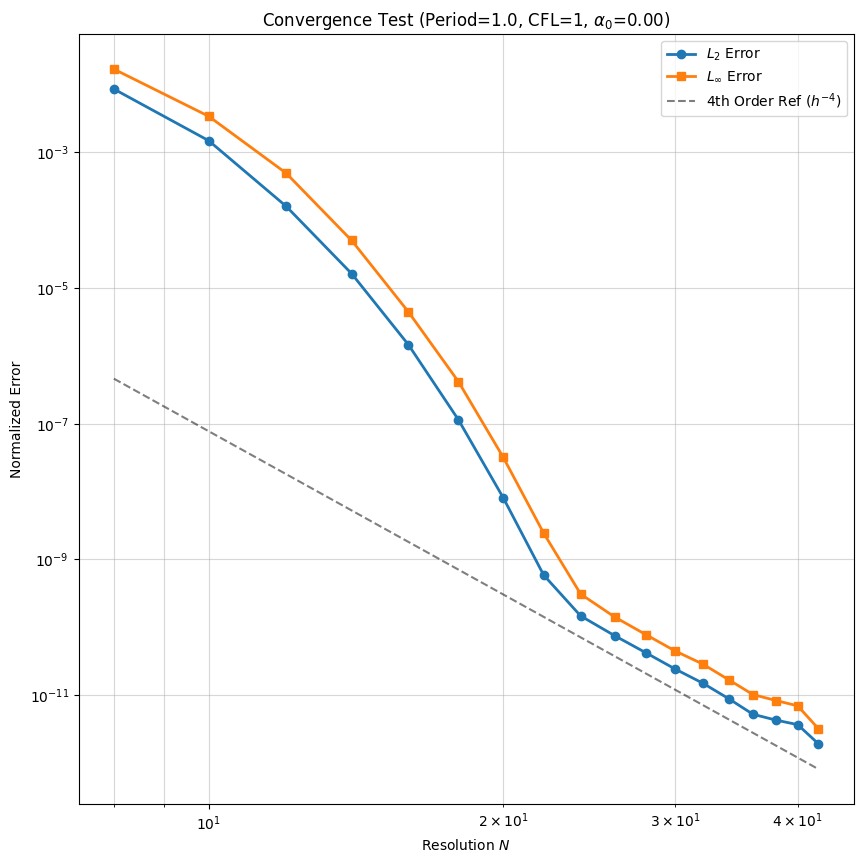

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import time

# =========================================================
# 1. 定義單個 N 的工作函數 (封裝所有參數)
# =========================================================
def worker_simulation(N, period, CFL, a, h0, alpha0, sigma_ratio):
    """
    單個 CPU 核心的完整工作流程：
    接收所有物理參數 -> 執行模擬 -> 重建同樣參數的精確解 -> 計算誤差
    """
    # 1. 執行模擬
    # 注意：run_simulation_lsrk 必須支援這些參數輸入
    # 如果你的 run_simulation_lsrk 參數名稱不同，請在此對應調整
    phi_final = run_simulation_lsrk(N=N, period=period, CFL=CFL, 
                                    a=a, h0=h0, alpha0=alpha0)
    
    # 2. 重建幾何與精確解 (用於計算誤差)
    # 這裡的參數必須與模擬時完全一致，否則誤差計算會錯誤
    R = np.sqrt(3.0) * a
    w = legendre_gll_weights(N) * (np.pi / 4.0)
    
    sqrt_g_list = []
    phi_exact = []
    
    for f_idx in range(1, 7):
        sqrt_g, _ = get_metrics(N, a, R, f_idx)
        sqrt_g_list.append(sqrt_g)
        
        X, Y, Z = get_global_coords(f_idx, N, a, R)
        lam, the = lonlat_from_xyz(X, Y, Z, R)
        
        # 取得精確解 (Gaussian Bell)
        # 注意：這裡使用傳入的 sigma_ratio
        phi_e = get_gaussian_bell_field(lam, the, R, h0, sigma_ratio=sigma_ratio)
        phi_exact.append(phi_e)
        
    # 3. 計算誤差
    l2, linf = compute_norm_errors(phi_final, phi_exact, sqrt_g_list, w)
    
    return (N, l2, linf)

# =========================================================
# 2. 主程式：平行收斂性測試 (接收所有參數)
# =========================================================
def run_convergence_test_parallel(N_values, period, CFL, 
                                  a=1.0, h0=1.0, alpha0=0.0, sigma_ratio=1/3.0):
    """
    主控制函數：負責分配任務給 CPU 並繪圖
    """
    print(f"=================================================")
    print(f"Starting Parallel Convergence Test (CPU)")
    print(f"-------------------------------------------------")
    print(f" Simulation Parameters:")
    print(f"   Period      : {period}")
    print(f"   CFL         : {CFL}")
    print(f"   Alpha0      : {alpha0} rad ({np.degrees(alpha0):.1f} deg)")
    print(f"   Radius Param: a={a}")
    print(f"   Bell Height : h0={h0}")
    print(f"   Sigma Ratio : {sigma_ratio}")
    print(f"   N list      : {N_values}")
    print(f"=================================================")
    
    start_time = time.time()

    # --- 平行運算核心 ---
    # 將所有參數透過 delayed 傳遞給 worker
    results = Parallel(n_jobs=-1, verbose=5)(
        delayed(worker_simulation)(N, period, CFL, a, h0, alpha0, sigma_ratio) 
        for N in N_values
    )
    
    end_time = time.time()
    print(f"\nAll simulations done in {end_time - start_time:.2f} seconds.")

    # --- 整理結果 ---
    results.sort(key=lambda x: x[0])
    
    N_sorted = [r[0] for r in results]
    errors_l2 = [r[1] for r in results]
    errors_linf = [r[2] for r in results]

    # --- 輸出表格 ---
    print("\n=== Convergence Results Summary ===")
    print(f"{'N':<5} | {'L2 Error':<12} | {'Order (L2)':<10} | {'Linf Error':<12} | {'Order (Linf)':<10}")
    print("-" * 65)
    
    for i, N in enumerate(N_sorted):
        order_l2 = 0.0
        order_linf = 0.0
        if i > 0:
            # 計算收斂階數
            log_err_l2_diff = np.log(errors_l2[i]) - np.log(errors_l2[i-1])
            log_err_linf_diff = np.log(errors_linf[i]) - np.log(errors_linf[i-1])
            log_N_diff = np.log(N_sorted[i]) - np.log(N_sorted[i-1])
            
            order_l2 = -(log_err_l2_diff / log_N_diff)/2
            order_linf = -(log_err_linf_diff / log_N_diff)/2
            
        print(f"{N:<5} | {errors_l2[i]:.4e}   | {order_l2:.2f}       | {errors_linf[i]:.4e}   | {order_linf:.2f}")

    # --- 繪圖 ---
    plt.figure(figsize=(10, 10))
    plt.loglog(N_sorted, errors_l2, 'o-', label=r'$L_2$ Error', linewidth=2)
    plt.loglog(N_sorted, errors_linf, 's-', label=r'$L_\infty$ Error', linewidth=2)
    
    # 畫參考線 (以 N^-4 為例)
    if len(N_sorted) > 0:
        ref_x = np.array(N_sorted)
        ref_y4 = (errors_l2[4]-1*1e-6) * (ref_x[0]/ref_x)**8 
        plt.loglog(ref_x, ref_y4, 'k--', alpha=0.5, label='4th Order Ref ($h^{-4}$)')
    
    plt.grid(True, which="both", ls="-", alpha=0.5)
    plt.xlabel('Resolution $N$')
    plt.ylabel('Normalized Error')
    plt.title(f'Convergence Test (Period={period}, CFL={CFL}, $\\alpha_0$={alpha0:.2f})')
    plt.legend()
    plt.show()

# =========================================================
# 3. 執行區塊 (在這裡調整所有參數)
# =========================================================
if __name__ == "__main__":
    # --- 1. 網格解析度設定 ---
    # 建議：先用少數幾個點測試 (如 [8, 12])，確認沒問題再跑完整列表
    test_N_values = range(8,43,2) 
    
    # --- 2. 時間積分參數 ---
    sim_period = 1.0   # 模擬週期 (跑幾圈)
    sim_CFL = 1       # CFL 數 (穩定性控制)
    
    # --- 3. 物理與幾何參數 ---
    # 這些參數現在都可以在這裡調整，並會同時應用於模擬與誤差計算
    radius_scale_a = np.sqrt(1/3)        # Cubed-Sphere 基礎半徑 a
    bell_height_h0 = 1.0        # 波峰高度
    flow_angle_alpha0 = 0.0     # 流動角度 (0=沿赤道, pi/2=過極點, pi/4=斜向)
    gaussian_sigma_ratio = 1/3.0 # Gaussian 波寬 (sigma = R * ratio)

    # --- 4. 執行 ---
    run_convergence_test_parallel(
        N_values=test_N_values,
        period=sim_period,
        CFL=sim_CFL,
        a=radius_scale_a,
        h0=bell_height_h0,
        alpha0=flow_angle_alpha0,
        sigma_ratio=gaussian_sigma_ratio
    )

In [114]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
import time

# =========================================================
# 1. 模擬與錄製核心 (CPU Version) - 保持不變
# =========================================================
def run_simulation_and_record(N, period, CFL, frames, a, h0, alpha0, sigma_ratio):
    print(f"--- CPU Simulation Start (N={N}) ---")
    start_time = time.time()
    
    # 1. 基礎參數計算
    R = np.sqrt(3.0) * a
    u0 = 2.0 * np.pi * R
    T_final = 2.0 * np.pi * R * period / u0
    
    # 2. 準備運算子
    D = get_derivative_matrix(N)
    w = legendre_gll_weights(N) * (np.pi / 4.0)
    
    # 3. 初始化
    metrics_cache = []
    wind_cache = []
    phi_global = []
    coords_cache = [] 
    
    for f_idx in range(1, 7):
        sqrt_g, A_inv = get_metrics(N, a, R, f_idx)
        metrics_cache.append((sqrt_g, A_inv))
        X, Y, Z = get_global_coords(f_idx, N, a, R)
        coords_cache.append((X, Y, Z))
        lam, the = lonlat_from_xyz(X, Y, Z, R)
        u_phys, v_phys = get_global_wind_solid_body(lam, the, R, u0, alpha0)
        dummy_U = np.ones_like(sqrt_g)
        _, _, u_contra, v_contra = compute_fluxes(dummy_U, u_phys, v_phys, A_inv)
        wind_cache.append((u_contra, v_contra))
        phi = get_gaussian_bell_field(lam, the, R, h0, sigma_ratio)
        phi_global.append(phi)

    # 4. 時間步長
    dt_cfl = compute_dt(N, R, u0, CFL=CFL)
    total_steps = int(np.ceil(T_final / dt_cfl))
    save_interval = max(1, total_steps // frames)
    
    print(f"Total Steps: {total_steps}, Saving every {save_interval} steps")
    
    # 5. 積分迴圈
    current_time = 0.0
    step = 0
    history = []
    history.append([p.copy() for p in phi_global])
    
    while current_time < T_final - 1e-15:
        if current_time + dt_cfl > T_final:
            dt = T_final - current_time
        else:
            dt = dt_cfl
            
        phi_global = time_step_lsrk45(phi_global, current_time, dt, D, w, metrics_cache, wind_cache)
        current_time += dt
        step += 1
        
        if step % save_interval == 0:
            history.append([p.copy() for p in phi_global])
            if len(history) % 10 == 0:
                print(f"Recorded frame {len(history)}/{frames+1}...", end='\r')

    if len(history) <= frames:
        history.append([p.copy() for p in phi_global])
        
    end_time = time.time()
    print(f"\nSimulation Done in {end_time - start_time:.2f}s. Total frames: {len(history)}")
    
    return history, coords_cache

# =========================================================
# 2. GIF 動畫繪製模組 (移除背景坐標系)
# =========================================================
def create_3d_gif(history, coords_cache, filename, view_elev, view_azim, fps):
    """
    將模擬數據轉換為 GIF 檔案，並移除所有軸標籤和背景網格。
    """
    print(f"Generating GIF Animation -> {filename}")
    print("Converting frames to GIF... This may take a minute.")
    
    # 提高 DPI 讓最終的 GIF 畫質更好
    fig = plt.figure(figsize=(10, 8), dpi=150) 
    ax = fig.add_subplot(111, projection='3d')
    
    # --- 1. 設定顏色範圍 ---
    all_vals = []
    for f in range(6):
        all_vals.extend(history[0][f].ravel())
        all_vals.extend(history[-1][f].ravel())
    
    vmin, vmax = np.min(all_vals), np.max(all_vals)
    if vmin > -0.1 * vmax: vmin = -0.1 * vmax 
    
    norm = plt.Normalize(vmin, vmax)
    cmap = plt.cm.viridis
    
    # 添加 Colorbar
    mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    mappable.set_array([])
    # 將 Colorbar 獨立放置，不受 ax.axis('off') 影響
    cbar = fig.colorbar(mappable, ax=ax, shrink=0.5, aspect=10, label="Phi")
    
    def update(frame_idx):
        ax.clear()
        
        # --- 關鍵修改：移除背景坐標系 ---
        ax.axis('off')  # 移除軸線、刻度、標籤
        ax.set_title(f"Advection (Frame {frame_idx}/{len(history)-1})", color='white') # 標題也設白色可能比較好融入背景
        
        # 固定軸限與比例 (維持球體不變形)
        limit = 2.0
        ax.set_xlim(-limit, limit)
        ax.set_ylim(-limit, limit)
        ax.set_zlim(-limit, limit)
        ax.set_box_aspect((1, 1, 1))
        
        # 設定背景色為黑色或透明 (若需要)
        #ax.set_facecolor('black') 
        #fig.patch.set_facecolor('black') # 整個圖的背景
        
        ax.view_init(elev=view_elev, azim=view_azim)
        
        # 繪圖
        phi_curr = history[frame_idx]
        for f in range(6):
            X, Y, Z = coords_cache[f]
            vals = phi_curr[f] 
            
            # 點到面顏色插值 (解決邊界裂縫問題)
            vals_centers = 0.25 * (vals[:-1, :-1] + vals[:-1, 1:] + 
                                   vals[1:, :-1] + vals[1:, 1:])
            colors = cmap(norm(vals_centers))
            
            ax.plot_surface(X, Y, Z, 
                            facecolors=colors, 
                            rstride=1, cstride=1, 
                            shade=False, antialiased=False, linewidth=0)
            
        return fig,

    # 建立動畫
    # 注意：如果背景設為透明，可能需要額外處理 GIF 輸出參數
    ani = animation.FuncAnimation(fig, update, frames=len(history), interval=1000/fps, blit=False)
    
    writer = animation.PillowWriter(fps=fps)
    ani.save(filename, writer=writer)
    
    print(f"GIF Animation saved successfully: {filename}")
    plt.close(fig)

# =========================================================
# 3. 參數設定與執行區塊
# =========================================================
if __name__ == "__main__":
    # A. 模擬參數
    SIM_PARAMS = {
        'N': 32,                # 網格解析度
        'period': 1.0,          
        'CFL': 0.5,
        'frames': 60,           # 幀數
        'a': np.sqrt(1/3),
        'h0': 1.0,
        'alpha0': -np.pi/4,     
        'sigma_ratio': 1/3.0
    }
    
    # B. 輸出設定
    VIS_PARAMS = {
        'filename': "spherical_advection_clean.gif", # 輸出檔案名稱
        'view_elev': 40,
        'view_azim': 0,
        'fps': 15
    }
    
    # 1. 跑模擬
    hist_data, grid_coords = run_simulation_and_record(**SIM_PARAMS)
    
    # 2. 產出 GIF
    create_3d_gif(hist_data, grid_coords, **VIS_PARAMS)

--- CPU Simulation Start (N=32) ---
Total Steps: 12868, Saving every 214 steps
Recorded frame 60/61...
Simulation Done in 17.24s. Total frames: 61
Generating GIF Animation -> spherical_advection_clean.gif
Converting frames to GIF... This may take a minute.
GIF Animation saved successfully: spherical_advection_clean.gif
